In [1]:
import os
from pathlib import Path
import pandas as pd
from collections import Counter

print("Imports loaded successfully!")


Imports loaded successfully!


In [4]:
BASE_DIR = Path(r"D:\MachineLearingProject\RDD2022")

BASE_DIR, BASE_DIR.exists()

(WindowsPath('D:/MachineLearingProject/RDD2022'), True)

In [5]:
countries = [d for d in BASE_DIR.iterdir() if d.is_dir()]

print("Found country folders:")
for c in countries:
    print(" -", c.name)

Found country folders:
 - China_Drone
 - China_MotorBike
 - Czech
 - India
 - Japan
 - Norway
 - United_States


In [6]:
print("Checking inside each country folder...\n")

for country_dir in countries:
    print(f"📁 {country_dir.name}/")
    
    inner_items = list(country_dir.iterdir())
    for item in inner_items:
        if item.is_dir():
            print("   -", item.name, "(folder)")
        else:
            print("   -", item.name, "(file)")
    
    print()


Checking inside each country folder...

📁 China_Drone/
   - train (folder)

📁 China_MotorBike/
   - test (folder)
   - train (folder)

📁 Czech/
   - test (folder)
   - train (folder)

📁 India/
   - test (folder)
   - train (folder)

📁 Japan/
   - test (folder)
   - train (folder)

📁 Norway/
   - test (folder)
   - train (folder)

📁 United_States/
   - test (folder)
   - train (folder)



In [7]:
def inspect_train_test_structure(country_dir):
    print(f"🔎 Inspecting {country_dir.name} ...")
    
    for split in ["train", "test"]:
        split_path = country_dir / split
        if split_path.exists():
            print(f"  ✔ {split} folder found")
            items = list(split_path.iterdir())
            for item in items:
                print(f"    - {item.name}")
        else:
            print(f"  ✖ No {split} folder")
    
    print()

# Run for all countries
for country_dir in countries:
    inspect_train_test_structure(country_dir)



🔎 Inspecting China_Drone ...
  ✔ train folder found
    - annotations
    - images
  ✖ No test folder

🔎 Inspecting China_MotorBike ...
  ✔ train folder found
    - annotations
    - images
  ✔ test folder found
    - images

🔎 Inspecting Czech ...
  ✔ train folder found
    - annotations
    - images
  ✔ test folder found
    - images

🔎 Inspecting India ...
  ✔ train folder found
    - annotations
    - images
  ✔ test folder found
    - images

🔎 Inspecting Japan ...
  ✔ train folder found
    - annotations
    - images
  ✔ test folder found
    - images

🔎 Inspecting Norway ...
  ✔ train folder found
    - annotations
    - images
  ✔ test folder found
    - images

🔎 Inspecting United_States ...
  ✔ train folder found
    - annotations
    - images
  ✔ test folder found
    - images



In [9]:
def count_files_in_country(country_dir):
    train_images = list((country_dir / "train" / "images").glob("*.jpg"))
    
    # Count XMLs inside annotations/xmls
    train_ann_path = country_dir / "train" / "annotations" / "xmls"
    train_ann = []
    if train_ann_path.exists():
        train_ann = list(train_ann_path.glob("*.xml"))
    
    test_images = []
    if (country_dir / "test").exists():
        test_images = list((country_dir / "test" / "images").glob("*.jpg"))
    
    return {
        "country": country_dir.name,
        "train_images": len(train_images),
        "train_annotations": len(train_ann),
        "test_images": len(test_images),
    }

summary = [count_files_in_country(c) for c in countries]
pd.DataFrame(summary)


,country,train_images,train_annotations,test_images
0,China_Drone,2401,2401,0
1,China_MotorBike,1977,1977,500
2,Czech,2829,2829,709
3,India,7706,7706,1959
4,Japan,10506,10506,2627
5,Norway,8161,8161,2040
6,United_States,4805,4805,1200


In [11]:
pip install opencv-python

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\App\python.exe -m pip install --upgrade pip


In [12]:
pip install opencv-python-headless

   ---------------------------------------- 0.0/38.9 MB ? eta -:--:--
   - -------------------------------------- 1.6/38.9 MB 12.6 MB/s eta 0:00:03
   ------- -------------------------------- 7.3/38.9 MB 21.0 MB/s eta 0:00:02
   ------------- -------------------------- 13.1/38.9 MB 23.5 MB/s eta 0:00:02
   --------------------- ------------------ 21.0/38.9 MB 27.2 MB/s eta 0:00:01
   ------------------------------ --------- 29.6/38.9 MB 29.6 MB/s eta 0:00:01
   ------------------------------------ --- 35.9/38.9 MB 30.5 MB/s eta 0:00:01
   ---------------------------------------- 38.9/38.9 MB 27.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\App\python.exe -m pip install --upgrade pip


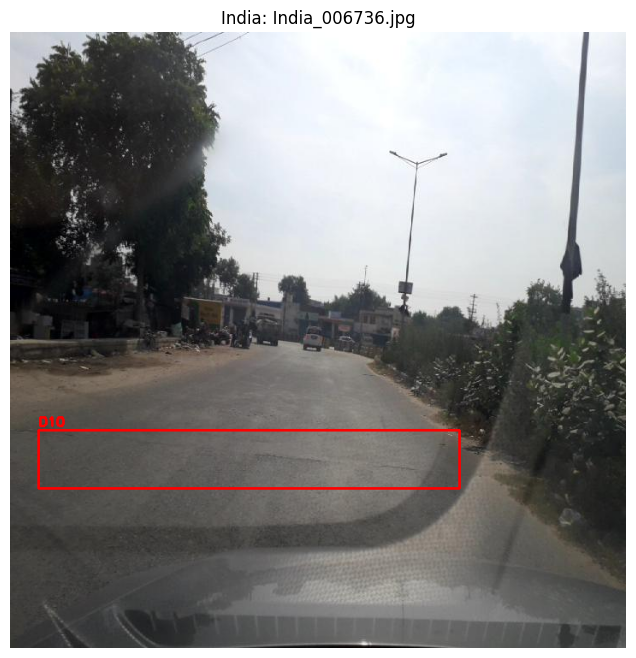

In [33]:
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt

def parse_voc_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    boxes = []
    labels = []
    
    for obj in root.findall("object"):
        label = obj.find("name").text
        bbox = obj.find("bndbox")
        
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)
    
    return boxes, labels


def show_random_image(country="Japan"):
    import random
    
    img_dir = BASE_DIR / country / "train" / "images"
    ann_dir = BASE_DIR / country / "train" / "annotations" / "xmls"
    
    img_files = list(img_dir.glob("*.jpg"))
    img_file = random.choice(img_files)
    
    # Matching annotation
    xml_file = ann_dir / (img_file.stem + ".xml")
    
    # Read image
    img = cv2.imread(str(img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Parse annotation
    boxes, labels = parse_voc_xml(xml_file)
    
    # Draw boxes
    for (xmin, ymin, xmax, ymax), label in zip(boxes, labels):
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(img, label, (xmin, ymin - 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title(f"{country}: {img_file.name}")
    plt.axis("off")
    plt.show()


# Show a sample
show_random_image("India")
